# Train and test the model

In [1]:
from preprocessor import Preprocessor
from batch_generator import BatchGenerator
from keras.optimizers import Adam
import modelling
import importlib
import evaluating

Using TensorFlow backend.


In [5]:
train_generator = BatchGenerator(64, 64, mode='train')
test_generator = BatchGenerator(64, 64, mode='test')

In [6]:
shapes = train_generator[0]
shapes[0][0].shape, shapes[0][1].shape, shapes[0][2].shape, shapes[0][3].shape, shapes[1].shape

((128, 20), (128, 20), (128, 11), (128, 9), (128, 1))

In [7]:
train_embedding_generator = BatchGenerator(64, 64, mode='train', return_stat=False)
test_embedding_generator = BatchGenerator(64, 64, mode='test', return_stat=False)

In [8]:
shapes = train_embedding_generator[0]
shapes[0][0].shape, shapes[0][1].shape, shapes[1].shape

((128, 20), (128, 20), (128, 1))

In [10]:
importlib.reload(modelling)

<module 'modelling' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\modelling.py'>

In [11]:
# model = Mothership_v1(15, [102, 42], 16, [102, 102, 42], 10, [2, 2], [2, 2, 2])
model = modelling.Mothership_v3(20, 11, [102, 42], [2, 2],
                                20, 9, [102, 102, 42], [2, 2, 2])

In [ ]:
model.embedding_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
model.embedding_model.fit_generator(train_embedding_generator, epochs=1)
model.embedding_model.evaluate_generator(test_embedding_generator)

In [30]:
model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, epochs=1)
model.evaluate_generator(test_generator)

Epoch 1/1
695/695 [==============================] - 52s 75ms/step - loss: 0.3614 - acc: 0.8406


[0.3323729700512356, 0.8588927469135802]

# Analyze model mistakes

In [24]:
import numpy as np

In [25]:
predictions = model.predict_generator(test_generator)

In [26]:
preds = np.round(predictions).reshape(-1)
preds

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [27]:
preds.shape

(10368,)

In [28]:
preds.shape[0] / 128

81.0

In [29]:
true_block = np.concatenate([np.ones(64), np.zeros(64)])
true = np.tile(true_block, 81)
true.shape

(10368,)

In [106]:
print('Accuracy:', np.mean(preds == true))

Accuracy: 0.7058256172839507


In [102]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
pred_positive = preds[preds == 1].shape[0]
precision = true_positive / pred_positive
print('Precision:', precision)

Precision: 0.7033155487804879


In [103]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
actual_positive = true[true == 1].shape[0]
recall = true_positive / actual_positive
print('Recall:', recall)

Recall: 0.7119984567901234


# Compute feature importance

In [59]:
fn = {
  "que_stat": [
    "students_location",
    "students_state",
    "students_questions_asked",
#     "students_average_question_age",
    "students_average_question_body_length",
#     "students_average_answer_body_length",
    "students_date_joined_time",
    "students_date_joined_doy_sin",
    "students_date_joined_doy_cos",
#     "students_date_joined_dow",
    "questions_body_length",
    "questions_date_added_time",
    "questions_date_added_doy_sin",
    "questions_date_added_doy_cos",
#     "questions_date_added_dow",
#     "questions_date_added_hour_sin",
#     "questions_date_added_hour_cos",
#     "questions_current_time",
  ],
  "pro_stat": [
    "professionals_industry",
    "professionals_location",
    "professionals_state",
    "professionals_questions_answered",
#     "professionals_average_question_age",
#     "professionals_average_question_body_length",
    "professionals_average_answer_body_length",
    "professionals_email_activated",
    "professionals_date_joined_time",
    "professionals_date_joined_doy_sin",
    "professionals_date_joined_doy_cos",
#     "professionals_date_joined_dow",
#     "professionals_last_answer_date_time",
#     "professionals_current_time"
  ]
}

In [60]:
fn['stat'] = fn['que_stat'] + fn['pro_stat']

In [61]:
fn['que_emb'] = [f'que_emb_{i}' for i in range(10)]
fn['que_emb'] += [f'que_tag_emb_{i}' for i in range(10)]
# fn['que_emb'] += [f'stu_tag_emb_{i}' for i in range(10)]

In [62]:
fn['pro_emb'] = [f'ind_emb_{i}' for i in range(10)]
fn['pro_emb'] += [f'pro_tag_emb_{i}' for i in range(10)]

In [63]:
len(fn['que_stat']), len(fn['pro_stat'])

(11, 9)

In [50]:
train_batch_generator = BatchGenerator(1024, 1024, mode='train')

In [51]:
train_batch_generator[0][0][0].shape, train_batch_generator[0][0][1].shape

((2048, 20), (2048, 20))

In [52]:
test_batch_generator = BatchGenerator(1024, 1024, mode='test')

In [53]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [69]:
importlib.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [70]:
fi = evaluating.permutation_importance(model, train_batch_generator[0][0], train_batch_generator[0][1], fn)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 84us/step


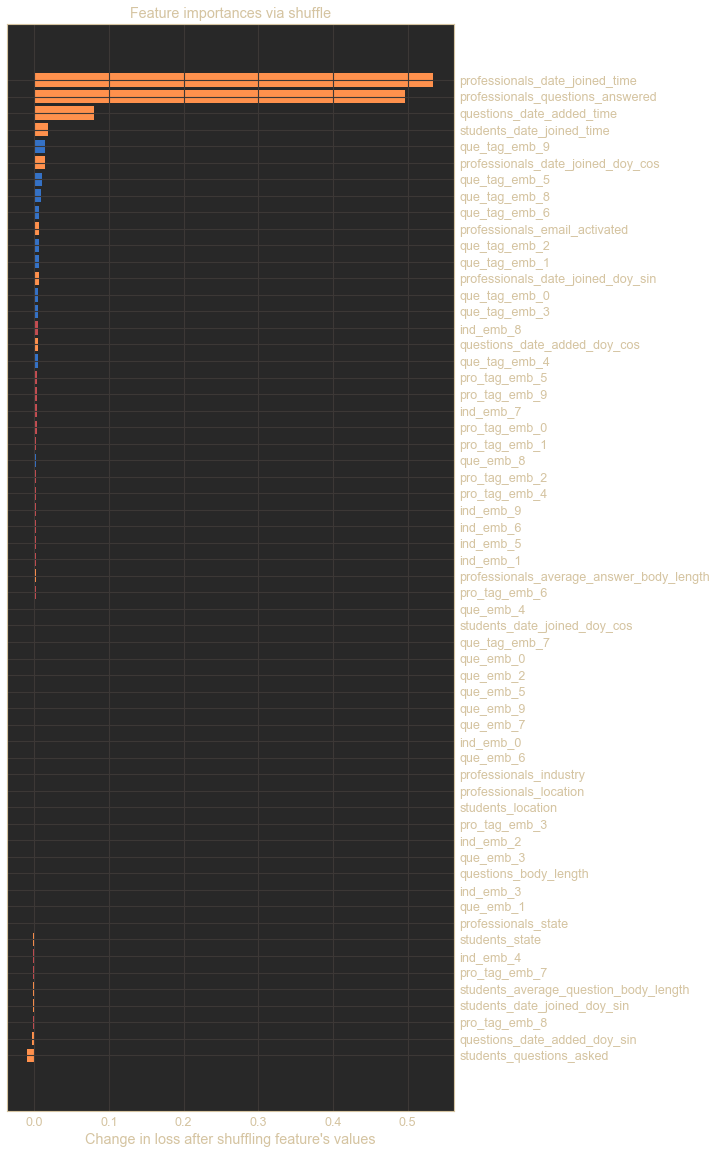

In [71]:
evaluating.plot_fi(fi, fn)

In [72]:
fi = evaluating.permutation_importance(model, test_batch_generator[0][0], test_batch_generator[0][1], fn)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 87us/step


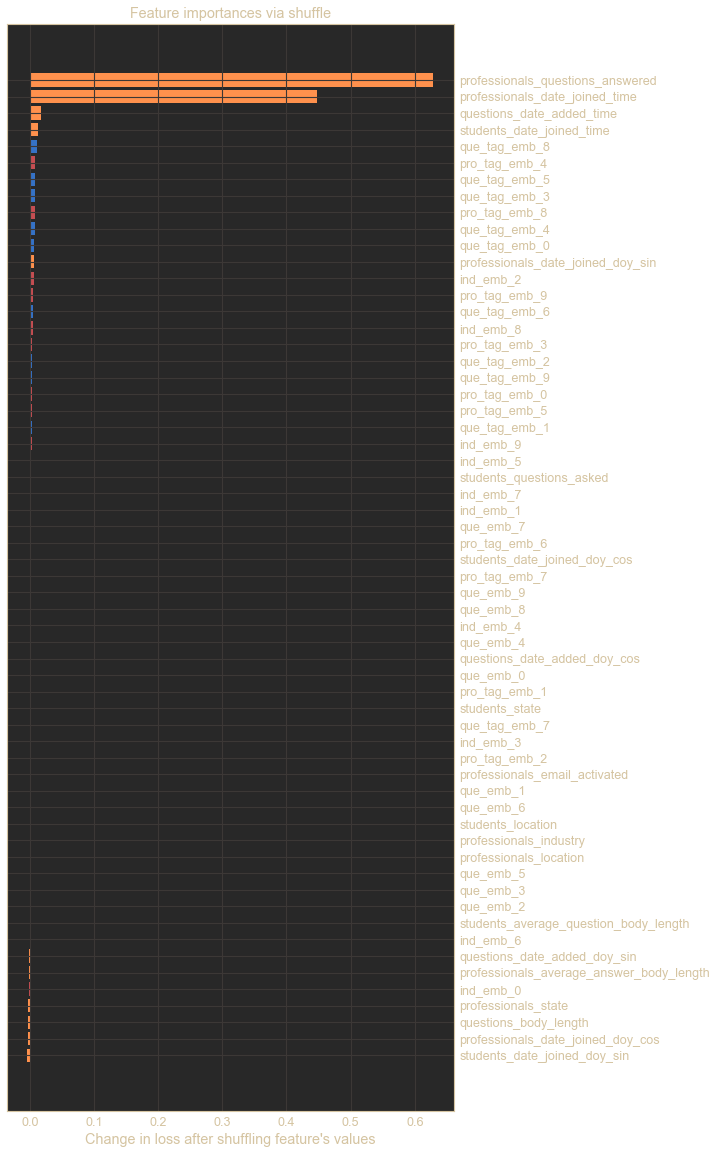

In [73]:
evaluating.plot_fi(fi, fn)